# Rag From Scratch: Routing


**Environment**

In [1]:
# pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube "sap-ai-sdk-gen[all]"


# Logical and Semantic routing

Use function-calling for classification.

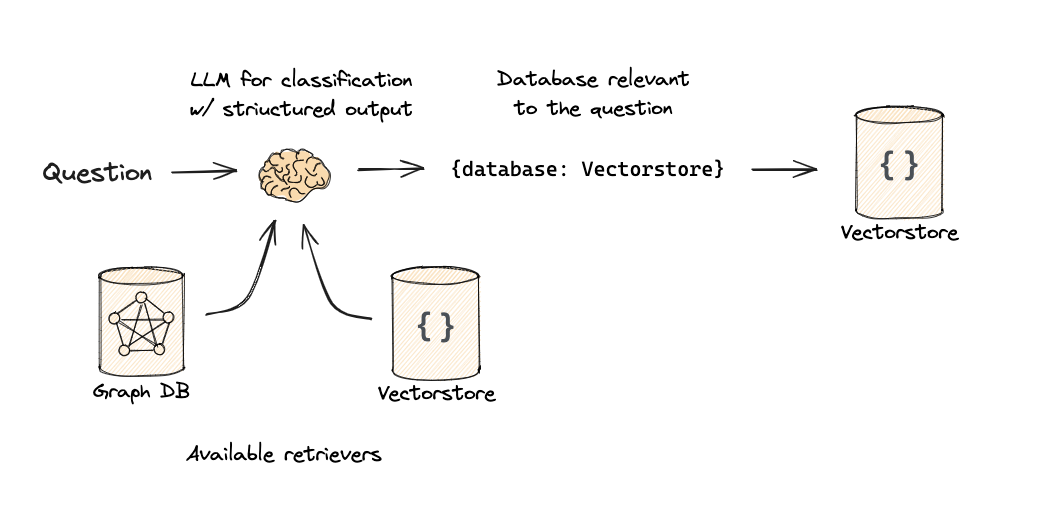

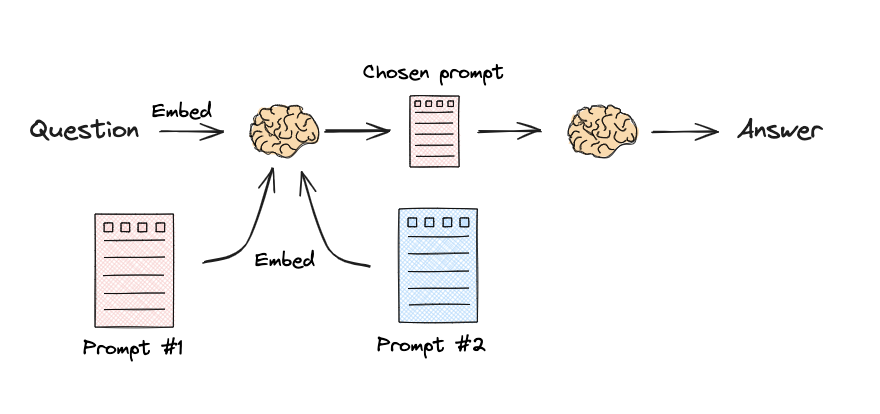

In [2]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

# LLM with function call 
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm(model_name="gpt-4o",temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router 
router = prompt | structured_llm

/Users/I562107/Documents/workspace/open_source/practice-projects/llmFromGroundUp/.venv/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


Note : we used function calling to produce structured output

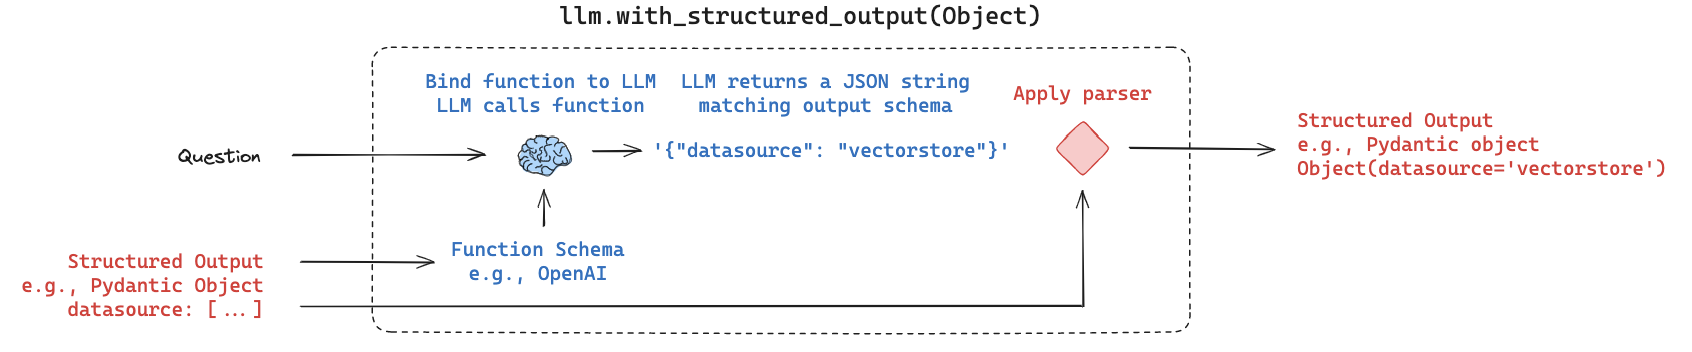

In [3]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

In [5]:
result
result.datasource

'python_docs'

In [6]:
### Once we have this, it is trivial to define a branch that uses result.datasource

def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for js_docs"
    else:
        ### Logic here 
        return "golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

In [8]:
final_response = full_chain.invoke({"question": question})
final_response


'chain for python_docs'

# Semantic Routing

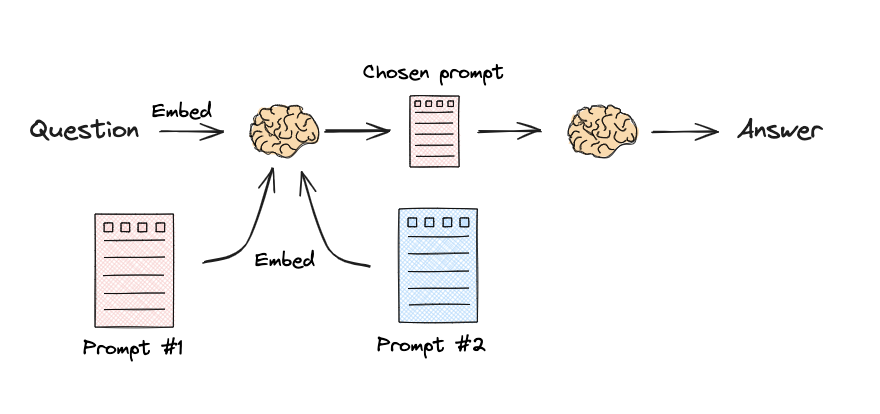

Docs:

- https://python.langchain.com/docs/expression_language/cookbook/embedding_router

In [ ]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
# from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from gen_ai_hub.proxy.langchain.init_models import init_embedding_model, init_llm

# Two prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""
# Initialize LLM for text generation
llm = init_llm(model_name="gpt-4o")

# Initialize embedding model for vector storage
# Embed prompts
embeddings = init_embedding_model(model_name="text-embedding-ada-002")
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Route question to prompt 
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt 
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | llm
    | StrOutputParser()
)

print(chain.invoke("What's a black hole"))

Using PHYSICS
A black hole is a region in space where the gravitational pull is so strong that nothing, not even light, can escape from it. This occurs when a massive star collapses under its own gravity at the end of its life cycle. The boundary around a black hole beyond which nothing can escape is called the event horizon. Inside the event horizon, the gravitational pull is so intense that the escape velocity exceeds the speed of light. The core of a black hole, where the mass is thought to be concentrated, is called the singularity, a point where density becomes infinite and the laws of physics as we know them break down.


# Query structuring for metadata filters
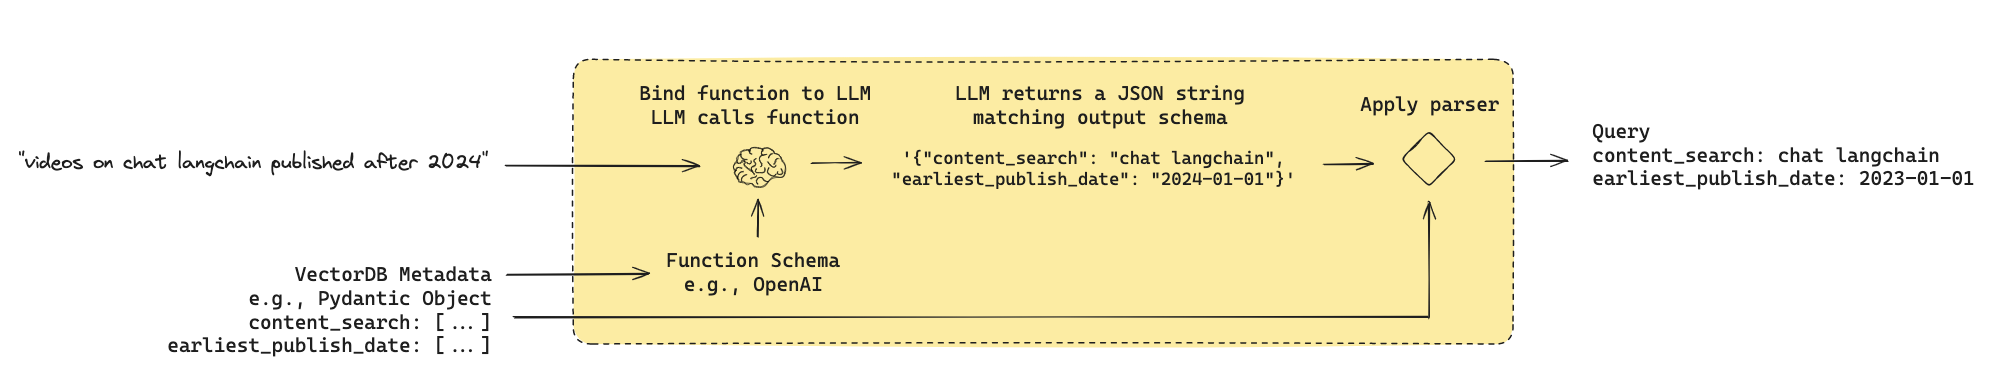

Many vectorstores contain metadata fields.

This makes it possible to filter for specific chunks based on metadata.

Let's look at some example metadata we might see in a database of YouTube transcripts.

Docs:

https://python.langchain.com/docs/use_cases/query_analysis/techniques/structuring

In [ ]:
# # Fix: Use below custom implementation which mimics langchain youtube loader but avoids pytube issues
# from langchain_community.document_loaders import YoutubeLoader

# try:
#     # First try without video metadata to avoid pytube HTTP 400 errors
#     loader =YoutubeLoader.from_youtube_url("https://www.youtube.com/watch?v=dQw4w9WgXcQ", add_video_info=True)
#     docs = loader.load()
#     print(f"✅ Successfully loaded {len(docs)} document(s)")
#     if docs:
#         print(f"First 200 chars: {docs[0].page_content[:200]}...")
#         print(f"Metadata: {docs[0].metadata}")
# except Exception as e:
#     print(f"❌ YoutubeLoader failed: {e}")
#     docs = []

# # If that fails, we'll use the robust fallback in the next cell


# ! uv pip install pytube youtube-transcript-api 
# ## ! uv pip install pytube==15.0.0 youtube-transcript-api==1.2.2   
# ! uv pip show pytube youtube-transcript-api

# ! uv pip uninstall pytube
# ! uv pip install pytube
# ! uv pip install --upgrade langchain-community

❌ YoutubeLoader failed: HTTP Error 400: Bad Request


In [35]:
# Simplified YouTube loader that mimics LangChain YoutubeLoader interface
from youtube_transcript_api import YouTubeTranscriptApi
from langchain.schema import Document
from typing import List
from urllib.parse import urlparse, parse_qs

class SimpleYoutubeLoader:
    """
    Simplified YouTube loader that mimics LangChain's YoutubeLoader interface
    Usage: loader = SimpleYoutubeLoader.from_youtube_url(url, add_video_info=True)
           docs = loader.load()
    """
    
    def __init__(self, youtube_url: str, add_video_info: bool = True):
        self.youtube_url = youtube_url
        self.add_video_info = add_video_info
        self.video_id = self._extract_video_id(youtube_url)
    
    @classmethod
    def from_youtube_url(cls, youtube_url: str, add_video_info: bool = True):
        """Create loader from YouTube URL - mimics LangChain interface"""
        return cls(youtube_url, add_video_info)
    
    def _extract_video_id(self, youtube_url: str) -> str:
        """Extract video ID from various YouTube URL formats"""
        parsed = urlparse(youtube_url)
        if parsed.hostname in ("youtu.be", "www.youtu.be"):
            return parsed.path.lstrip("/")
        if parsed.hostname in ("youtube.com", "www.youtube.com", "m.youtube.com"):
            qs = parse_qs(parsed.query)
            return qs.get("v", [None])[0]
        return parsed.path.split("/")[-1]
    
    def load(self) -> List[Document]:
        """Load YouTube transcript and return Document objects"""
        if not self.video_id:
            raise ValueError(f"Could not extract video ID from URL: {self.youtube_url}")
        
        # Initialize metadata
        metadata = {
            "source": self.youtube_url,
            "video_id": self.video_id,
        }
        
        # Add video info if requested
        if self.add_video_info:
            metadata.update({
                "title": f"YouTube Video {self.video_id}",
                "author": "Unknown",
                "length": None,
                "views": None,
                "description": None,
                "publish_date": None,
                "keywords": [],
            })
            
            # Try to get metadata using pytube
            try:
                from pytube import YouTube
                yt = YouTube(self.youtube_url)
                metadata.update({
                    "title": yt.title or f"YouTube Video {self.video_id}",
                    "author": yt.author or "Unknown",
                    "length": yt.length,
                    "views": yt.views,
                    "description": (yt.description[:500] + "..." if yt.description and len(yt.description) > 500 
                                  else yt.description) if yt.description else None,
                    "publish_date": str(yt.publish_date) if yt.publish_date else None,
                    "keywords": yt.keywords[:10] if yt.keywords else [],
                })
            except Exception:
                # Silently continue with basic metadata if pytube fails
                pass
        
        # Get transcript using youtube-transcript-api
        try:
            api = YouTubeTranscriptApi()
            transcript_list = api.list(self.video_id)
            available_transcripts = list(transcript_list)
            
            if not available_transcripts:
                raise RuntimeError("No transcripts available")
            
            # Get first available transcript
            selected_transcript = available_transcripts[0]
            raw_transcript = selected_transcript.fetch()
            
            # Get transcript info for metadata
            transcript_type = "manual" if (hasattr(selected_transcript, 'is_manually_created') 
                                         and selected_transcript.is_manually_created) else "auto_generated"
            language_code = getattr(selected_transcript, 'language_code', 'en')
            
            # Add transcript metadata
            metadata.update({
                "transcript_type": transcript_type,
                "language": language_code
            })
            
            # Convert to single document (like original LangChain loader)
            full_text = " ".join([item.text for item in raw_transcript if hasattr(item, 'text')])
            
            return [Document(page_content=full_text, metadata=metadata)]
            
        except Exception as e:
            raise RuntimeError(f"Failed to load YouTube transcript: {e}")

# Test the simplified loader with the same interface as LangChain
print("🔧 Testing simplified YouTube loader...")

# Example 1: With video info (like LangChain default)
try:
    loader = SimpleYoutubeLoader.from_youtube_url("https://www.youtube.com/watch?v=lG7Uxts9SXs", add_video_info=True)
    docs = loader.load()
    print(f"✅ With video info: Got {len(docs)} document(s)")
    print(f"📊 Metadata keys: {list(docs[0].metadata.keys())}")
    print(f"📄 Content preview: {docs[0].page_content[:200]}...")
except Exception as e:
    print(f"❌ With video info failed: {e}")

print()

print("\n🎉 Simplified loader ready! Use exactly like LangChain YoutubeLoader:")

🔧 Testing simplified YouTube loader...
✅ With video info: Got 1 document(s)
📊 Metadata keys: ['source', 'video_id', 'title', 'author', 'length', 'views', 'description', 'publish_date', 'keywords', 'transcript_type', 'language']
📄 Content preview: Lang chain is a framework designed to simplify the creation of applications using large language models it makes it easy to connect AI models with a bunch of different data sources so you can create c...


🎉 Simplified loader ready! Use exactly like LangChain YoutubeLoader:
✅ With video info: Got 1 document(s)
📊 Metadata keys: ['source', 'video_id', 'title', 'author', 'length', 'views', 'description', 'publish_date', 'keywords', 'transcript_type', 'language']
📄 Content preview: Lang chain is a framework designed to simplify the creation of applications using large language models it makes it easy to connect AI models with a bunch of different data sources so you can create c...


🎉 Simplified loader ready! Use exactly like LangChain YoutubeLoa

In [44]:
docs[0].metadata

{'source': 'https://www.youtube.com/watch?v=lG7Uxts9SXs',
 'video_id': 'lG7Uxts9SXs',
 'title': 'YouTube Video lG7Uxts9SXs',
 'author': 'Unknown',
 'length': None,
 'views': None,
 'description': None,
 'publish_date': None,
 'keywords': [],
 'transcript_type': 'auto_generated',
 'language': 'en'}

Let’s assume we’ve built an index that:

Allows us to perform unstructured search over the contents and title of each document
And to use range filtering on view count, publication date, and length.
We want to convert natural language into structured search queries.

We can define a schema for structured search queries.

In [37]:
import datetime
from typing import Literal, Optional, Tuple
from langchain_core.pydantic_v1 import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts.",
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
        ),
    )
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )

    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

/Users/I562107/Documents/workspace/open_source/practice-projects/llmFromGroundUp/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
from langchain_core.prompts import ChatPromptTemplate


system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm(model_name="gpt-4o",temperature=0)
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

/Users/I562107/Documents/workspace/open_source/practice-projects/llmFromGroundUp/.venv/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1936: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [40]:
query_analyzer.invoke({"question": "rag from scratch"}).pretty_print()

content_search: RAG from scratch
title_search: RAG from scratch


In [41]:
query_analyzer.invoke(
    {"question": "videos on chat langchain published in 2023"}
).pretty_print()

content_search: chat langchain
title_search: chat langchain
earliest_publish_date: 2023-01-01
latest_publish_date: 2024-01-01


In [42]:
query_analyzer.invoke(
    {"question": "videos that are focused on the topic of chat langchain that are published before 2024"}
).pretty_print()

content_search: chat langchain
title_search: chat langchain
latest_publish_date: 2024-01-01


In [43]:
query_analyzer.invoke(
    {
        "question": "how to use multi-modal models in an agent, only videos under 5 minutes"
    }
).pretty_print()

content_search: use multi-modal models in an agent
title_search: multi-modal models agent
max_length_sec: 300


To then connect this to various vectorstores, you can follow [here](https://python.langchain.com/docs/modules/data_connection/retrievers/self_query#constructing-from-scratch-with-lcel).